In [1]:
import sys
sys.path.append("C:/Users/jnevin/Documents/GitHub/networkdiffusionanalyser")

from netdiffanalyse import IntegrationPipeline
from netdiffanalyse.datahandling.dataintegration import FeatureSetup, MatchClassifier, NetworkIntegrator
from netdiffanalyse.diffusionmodel.diffusionmodel import CustomDiffusionModel, InitialisedDiffusionModel
from netdiffanalyse.analyser.networkanalysis import ResultsAnalyser
%matplotlib inline

no display found. Using non-interactive Agg backend
no display found. Using non-interactive Agg backend
no display found. Using non-interactive Agg backend


In [2]:
import pandas as pd
import numpy as np
import networkx as nx

test_df = pd.read_csv('dedup_test_df.csv')
test_df.index = test_df.rec_id
test_df = test_df.drop(columns = ['rec_id'])

test_matches = np.load('dedup_test_matches.npy', allow_pickle = True)
test_matches = pd.MultiIndex.from_tuples(test_matches)

test_graph = nx.read_gml('dedup_test_graph.gml')

In [3]:
test_df

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-223-org,NaN,waller,6.0,tullaroop street,willaroo,st james,4011,wa,19081209.0,6988048
rec-122-org,lachlan,berry,69.0,giblin street,killarney,bittern,4814,qld,19990219.0,7364009
rec-373-org,deakin,sondergeld,48.0,goldfinch circuit,kooltuo,canterbury,2776,vic,19600210.0,2635962
rec-10-dup-0,kayla,harrington,NaN,maltby circuit,coaling,coolaroo,3465,nsw,19150612.0,9004242
rec-227-org,luke,purdon,23.0,ramsay place,mirani,garbutt,2260,vic,19831024.0,8099933
...,...,...,...,...,...,...,...,...,...,...
rec-188-dup-0,stephanie,geu,28.0,bainton crescent,masonic memorial village,maryborough,2541,sa,19421008.0,3997529
rec-334-dup-0,nicholas,NaN,289.0,britten-jonues drive,jabaru court,paddington,2000,vic,19970422.0,5062738
rec-469-dup-0,lachlan,katsiavos,29.0,paul coe cdrescent,NaN,casual,2913,nsw,19380406.0,4112327


In [4]:
test_dict = test_df.to_dict()
full_graph_attr = test_graph.copy()

for attribute in test_dict:
    nx.set_node_attributes(full_graph_attr, test_dict[attribute], attribute)

In [5]:
# could be combined into a json config file and pass to integration pipeline
# method that calls all 4 blocks, compares, etc., and then one that wraps and calls on all pairwise comparison
graphs = [full_graph_attr]
test_blocks = {'Block': [['given_name', 'given_name']]}
test_compares = {'Exact':  [['given_name', 'given_name'], ['date_of_birth', 'date_of_birth'],
                          ['suburb', 'suburb'], ['state', 'state']],
                'String': [['surname', 'surname', 'jarowinkler', 0.85], ['address_1', 'address_1', 'levenshtein', 0.85]]}
classifier_name = 'NaiveBayesClassifier'
clustering_alg = 'walktrap_integration'
statuses = ['Susceptible', 'Infected', 'Removed']
compartments = {'NodeStochastic': {'c1': [0.02, 'Infected'], 'c2': [0.01]}}
transition_rules = [["Susceptible", "Infected", "c1"], ["Infected", "Removed", "c2"]]
model_parameters = [['fraction_infected', 0.1]]
simulation_parameters = [4, 300, None, 4]
model_name = 'sir'
training_matches = test_matches

In [6]:
# network integration step
test_feature_setup = FeatureSetup(test_blocks, test_compares, test_df)
test_features = test_feature_setup.calculate_features()

test_classifier = MatchClassifier('NaiveBayesClassifier', test_features, test_matches)
classifier_model = test_classifier.fit_model()
pred_matches = classifier_model.predict(test_features)

test_network_integrator = NetworkIntegrator(test_graph, pred_matches)
adj_graph = test_network_integrator.integrate_network('walktrap_integration')

In [7]:
# diffusion model
custom_diffusion_model = CustomDiffusionModel(statuses, compartments,
                                             transition_rules, model_parameters)
initialised_diffusion_model = InitialisedDiffusionModel(adj_graph, custom_diffusion_model)
trends = initialised_diffusion_model.run_diffusion_model(simulation_parameters)

In [8]:
# results analyser setup
results_analyser = ResultsAnalyser(initialised_diffusion_model.model, initialised_diffusion_model.graph,
                                   trends)

In [9]:
results_analyser.get_graph_properties()

{'num_nodes': 646,
 'num_edges': 996,
 'connected': False,
 'degree_cent': {'rec-223-org': 0.024806201550387597,
  'rec-122-org': 0.05581395348837209,
  'rec-227-org': 0.013953488372093023,
  'rec-344-org': 0.020155038759689922,
  'rec-34-org': 0.03255813953488372,
  'rec-478-org': 0.007751937984496124,
  'rec-225-org': 0.043410852713178294,
  'rec-286-org': 0.018604651162790697,
  'rec-439-org': 0.0031007751937984496,
  'rec-251-org': 0.009302325581395349,
  'rec-409-org': 0.004651162790697674,
  'rec-70-org': 0.018604651162790697,
  'rec-58-org': 0.017054263565891473,
  'rec-149-org': 0.004651162790697674,
  'rec-364-org': 0.004651162790697674,
  'rec-403-org': 0.013953488372093023,
  'rec-167-org': 0.010852713178294573,
  'rec-262-org': 0.009302325581395349,
  'rec-440-org': 0.0031007751937984496,
  'rec-113-org': 0.006201550387596899,
  'rec-152-org': 0.007751937984496124,
  'rec-99-org': 0.004651162790697674,
  'rec-482-org': 0.009302325581395349,
  'rec-287-org': 0.01550387596899

In [10]:
results_analyser.get_average_statistics()

{'Susceptible_peak': 0.9009287925696594,
 'Infected_peak': 0.3444272445820433,
 'Removed_peak': 0.6938854489164088,
 'Susceptible_final': 0.20743034055727555,
 'Infected_final': 0.09868421052631579,
 'Removed_final': 0.6938854489164088}

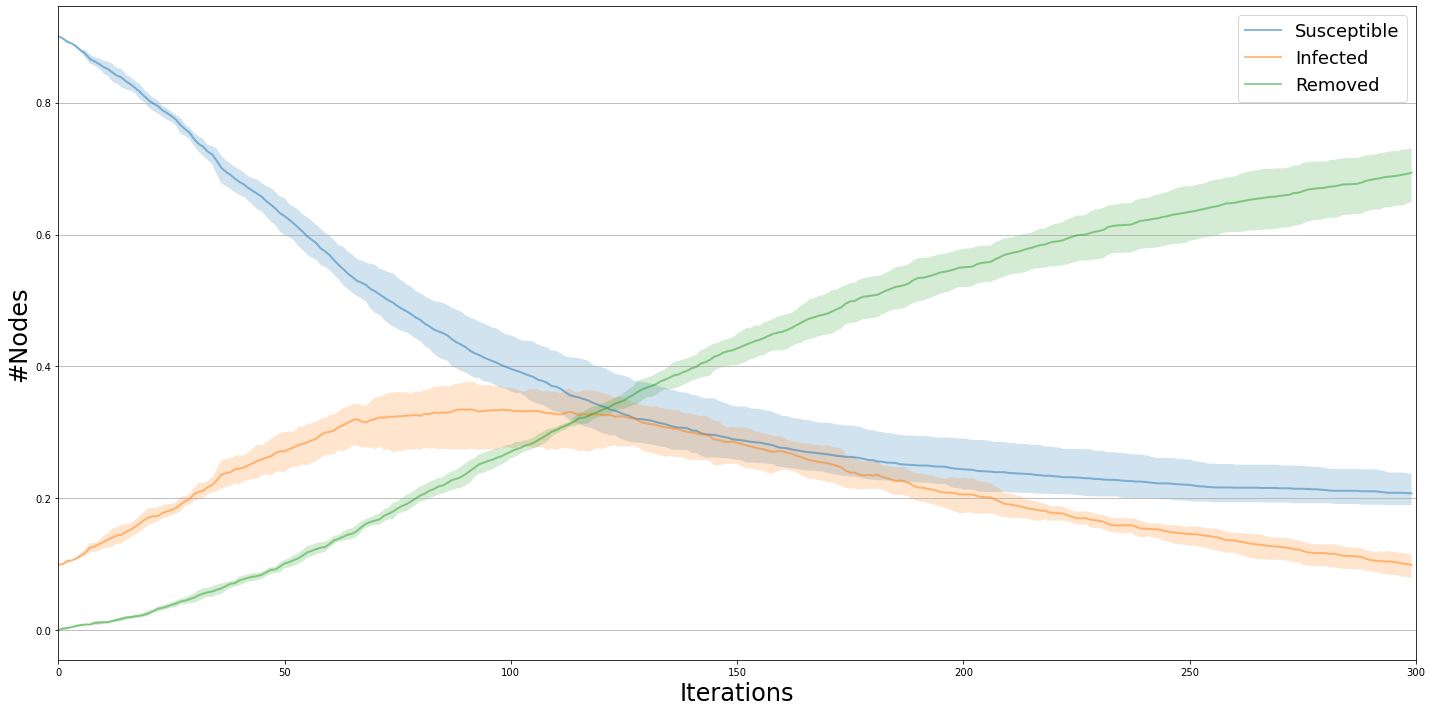

In [11]:
results_analyser.plot_diff_trend()

In [ ]:
integration_pipeline = IntegrationPipeline(graphs, test_blocks, test_compares, classifier_name,
                     clustering_alg, statuses, compartments, transition_rules,
                     model_parameters, simulation_parameters, model_name = model_name,
                     training_matches = training_matches)

In [ ]:
integration_pipeline.results_analyser.get_graph_properties()

In [ ]:
integration_pipeline.results_analyser.plot_diff_trend()

In [ ]:
integration_pipeline.results_analyser.get_average_statistics()

In [ ]:
# integrator checks

In [12]:
len(test_feature_setup.candidate_links) # 2082

2082

In [13]:
test_features.sum(axis=1).value_counts().sort_index(ascending=False) # 142, 145, 30, 9, 376, 1380

6.0     142
5.0     145
4.0      30
3.0       9
2.0     376
1.0    1380
dtype: int64

In [14]:
org_graph = test_network_integrator.graphs
len(org_graph.nodes()) # 922

922

In [15]:
len(adj_graph.nodes()) # 646

646